# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 6: *HTCirlceDecomposition*
Circle detection by the Hough transform decomposition
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, plotImageF, plotImageL, createScaleImageL, createVectorF, createImageF
from ImageOperatorsUtilities import applyCannyEdgeDetector
from ImagePropertiesUtilities import imageArgMax, peakDetectorVector
from PlotUtilities import plot3DHistogram, plotHistogram 

# Math and iteration
from math import sqrt, pi, sin, cos
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    gaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    upperT = Upper threshold
    lowerT = Lower threshold
    deltaPointRange = How far is the second point

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter6/Input/")
imageName = "EyeClose.png"
gaussianKernelSize = 9
sobelKernelSize = 3
upperT = 0.4
lowerT = 0.1
deltaPointRange = [30,35]

### Read and show input image

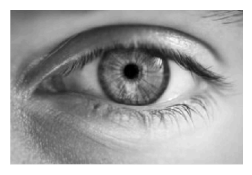

In [3]:
inputImage, width, height  = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 3)

### Compute edges

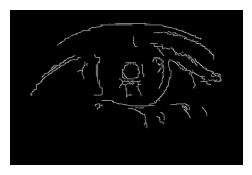

In [4]:
magnitude, angle = applyCannyEdgeDetector(inputImage, gaussianKernelSize, sobelKernelSize, upperT, lowerT)
plotImageF(magnitude, figureSize = 3)

### Gather evidence for the circle location by using two points

In [5]:
accumulator = createImageF(width, height)
for x1,y1 in itertools.product(range(0, width), range(0, height)):
    if magnitude[y1,x1] != 0:
        # Look for points at this distance
        for dx,dy in itertools.product(range(0,deltaPointRange[1]+1),                  \
                                       range(0,deltaPointRange[1]+1)):
        
            if (dx!=0 or dy!=0) and (abs(dx) > deltaPointRange[0] or                   \
                                     abs(dy) > deltaPointRange[0]):
                x2, y2 = x1+dx, y1+dy
                if x2 > 0 and y2 > 0 and x2 < width and y2 < height and                \
                                                  magnitude[y2, x2] !=0:
                    xm, ym = (x1 + x2) / 2.0, (y1 + y2) / 2.0                    
                    if abs(dx) < abs(dy):
                        m = float(dx) / float(-dy)
                        for x in range(0, width):
                            y = m *(x - xm) + ym
                            intY = int(y)
                            if intY > 0 and intY < height -1:
                                weight = y - intY
                                accumulator[ intY,   x] += (1.0 - weight)
                                accumulator[ intY+1, x] += weight
                    else:
                        m = float(-dy) / float(dx)
                        for y in range(0, height):
                            x = m *(y - ym) + xm
                            intX = int(x)
                            if intX > 0 and intX < width -1:
                                weight = x - intX
                                accumulator[ y, intX] += (1.0 - weight)
                                accumulator[ y, intX+1] += weight

### Find maximum

In [7]:
maximumPos = imageArgMax(accumulator)
maximum = accumulator[maximumPos[0],maximumPos[1]]

### Plot a slide of the accumulator

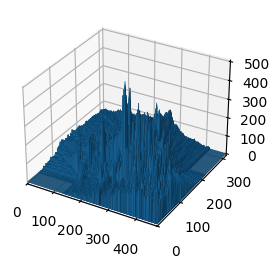

In [9]:
plot3DHistogram(accumulator)

### Accumulator for the radius

In [11]:
# Prepare output image as a dark version of the input
outputImage = createScaleImageL(inputImage, 0.5)

maxR = int(max(width, height)/2)
accR = createVectorF(maxR)
for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0:
        # Look for points at this distance
        r = sqrt( (maximumPos[1] - x) * (maximumPos[1] - x) +     \
                  (maximumPos[0] - y) * (maximumPos[0] - y) )
        bucket = int(r)
        if bucket> 0 and bucket < maxR - 1:
            weight = r - int(r)
            accR[bucket] += (1.0 - weight)
            accR[bucket+1] += weight

### Get maximum

In [13]:
maximumR = imageArgMax(accR)[0]

### Plot histogram

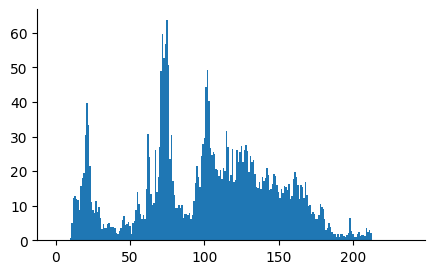

In [15]:
plotHistogram(accR)

### Draw located circle

In [17]:
for m in range(0,360):
    angle = (m * pi) / 180.0
    x = int(maximumPos[1]- maximumR * cos(angle));
    y = int(maximumPos[0]- maximumR * sin(angle));
    if x<width and x>0 and y<height and y>0:
        outputImage[y,x] = 255  

### Show image with detected circle

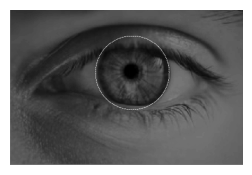

In [21]:
plotImageL(outputImage, figureSize = 3)